# ITF TC 1.2.2.8 NoteBook
|||
|---|---|
|**Test ID:** | SKAO-TC-4165 |
|**Test Plan:**|TBA|
|**Test Cycle:**|TBA|
|**Jama Test Case Link:**| https://skaoffice.jamacloud.com/perspective.req?docId=1004595&projectId=335|
|**Remarks on Requirements:**| The following ICDs have been used as reference:LOW CBF to LOW SPS ICD (111-000000-024 LOW CBF to LOW SPS Interface Control Document (ICD)) LOW SPS to PaSD Fibre Routing and Networking ICD (Jama Module) (Under Change)|

## Author: Lee Render

## Description
**Preconditions**

* PC1 Test computer is connected to the NSDN.
* PC2 Kubernetes cluster with TMC, MCCS, CSP, SDP and EDA are deployed. 
* PC3 MCCS deployment will be a minimal version with Monitor and Control functionality and CSP.LMC depolyment will be a minimal version with basic monitor and control of the CBF.
* PC4 The TPMs in ITF SPS are organised into two subracks, two TPM cards per subrack. The two subracks are configured to represent processing of separate stations.
* PC5 SPS and CSP systems are initialised and set to operational state.
* PC6 Assigning of the resources and configuration for the scan are hardcoded for this test.
* PC7 Analog portion of the Signal Chain is setup and confirmed to be working as per SKAO-TSTRN-279

**Procedure** 

The Test Case aims to check the flow of science data through the SPS and into CSP.CBF. Different artificial sky signals are generated  by the Analog Chain and fed to the SPS, examined for their integrity through the samplers and after channelisation, and checked for correctness of their summation/aggregation in the beam formers and as streamed out of the SPS elements. A check is made that the signals received at the CSP-CBF is identical to that forwarded from SPS.

A pair of analog signals are input to each TPM card; in all eight signals are input into the four TPM cards from test & measurement instruments. Test is made of integrity of the signal flow for three cases: (a) where the pair of analog signals going into each TPM card are both to X polarisation inputs, (b) where the pair of analog signals going into each TPM card are both to Y polarisation inputs, and (c) where the pair of analog signals going into each TPM card are to X and Y polarisation inputs.

The signals generated are sine waves and uncorrelated wideband noise. The sine wave signal power is set to be at +9 dBm [1]; wideband noise is band limited to 400 MHz, with integrated power in each input set to be -2.7 dBm [2]. TPM 1.1 and TPM 2.1 are given sine wave signals, TPM 1.2 and TPM 2.2 are given wideband noise waveforms. The different inputs provide a check that aggregation into station beams successfully combine the sine waves with wideband noise. Sinewaves to Subrack 1 are set to frequency 81.25 MHz; the sinewaves to Subrack 2 are set to 243.75 MHz. The different inputs to different TPMs check for spectral, temporal and polarisation constituents and ordering in the signal flow, through beam forming and transmission from SPS to CBF.

 

[1] Set empirically; High enough to enable SIne Wave to be visible above noise level, but low enough to avoid clipping in TPM. 

[2] Set as per Table 1 in Comoretto, G. et al. (2020) ‘The signal processing chain of the Low Frequency Aperture Array’, in Proceedings of SPIE - The International Society for Optical Engineering. [Online]. 2020 SPIE. pp. 1144571–1144571–14.

## Diagrams

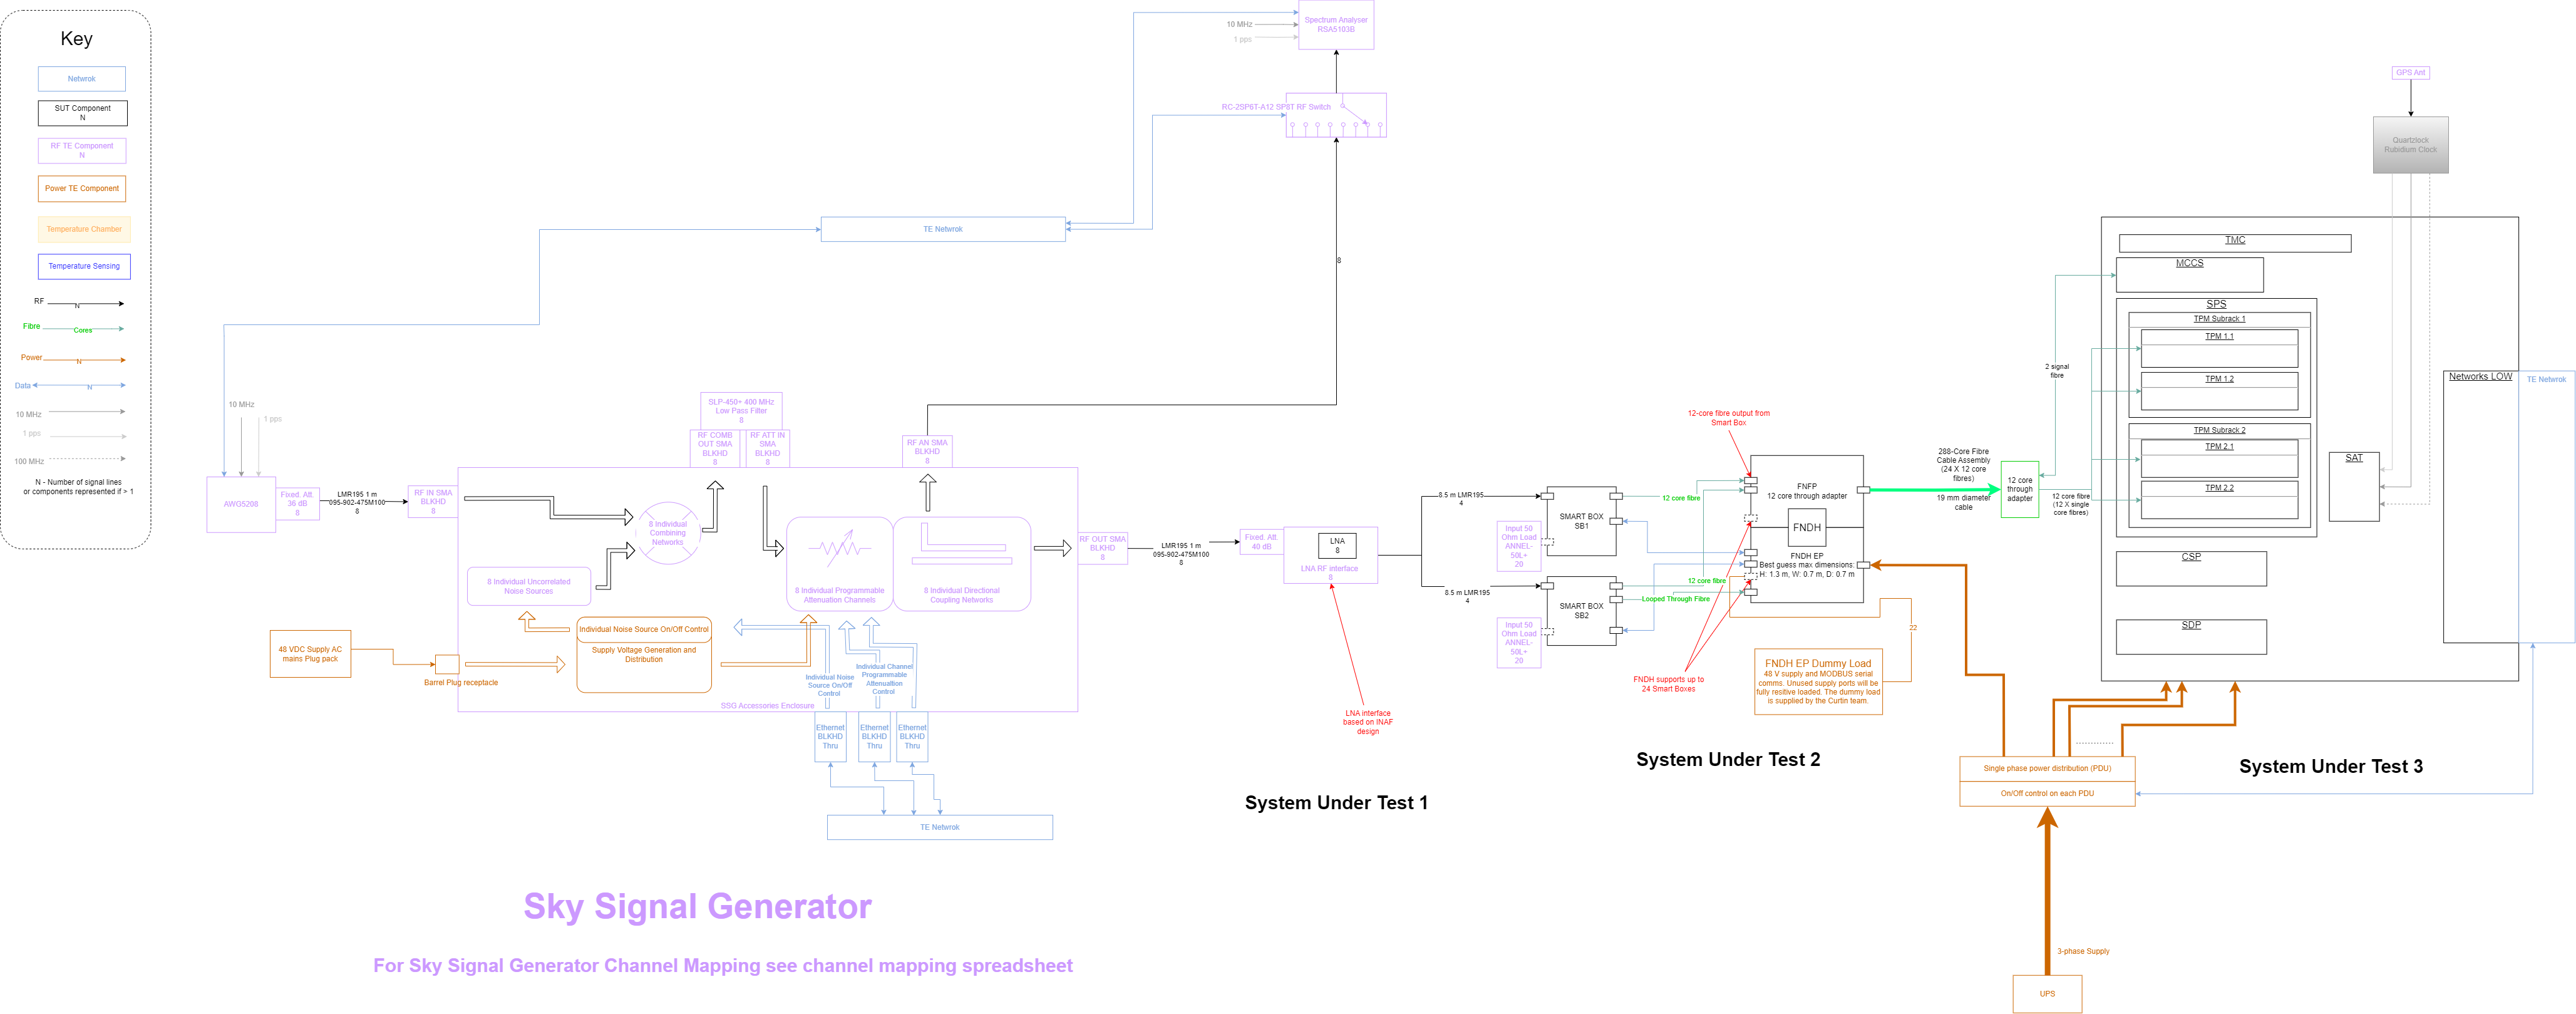

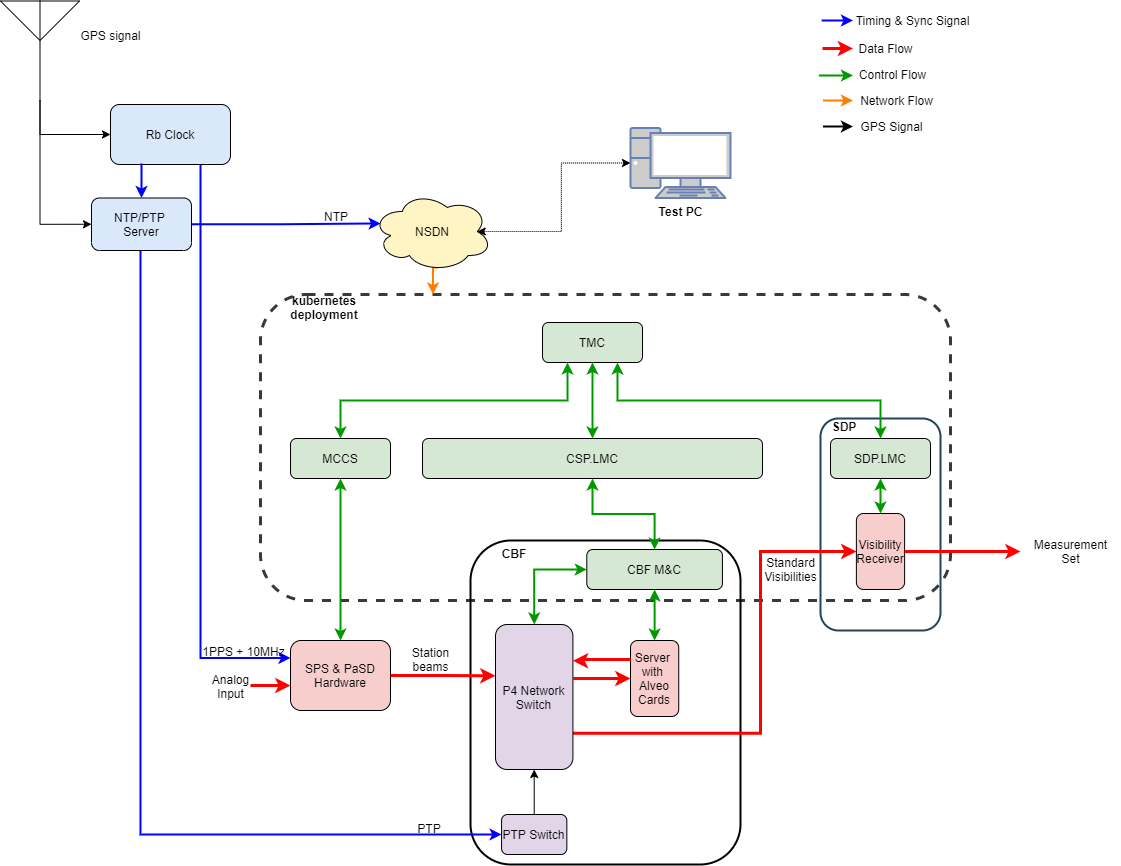

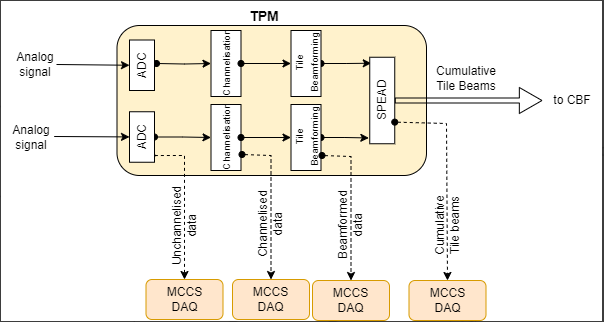

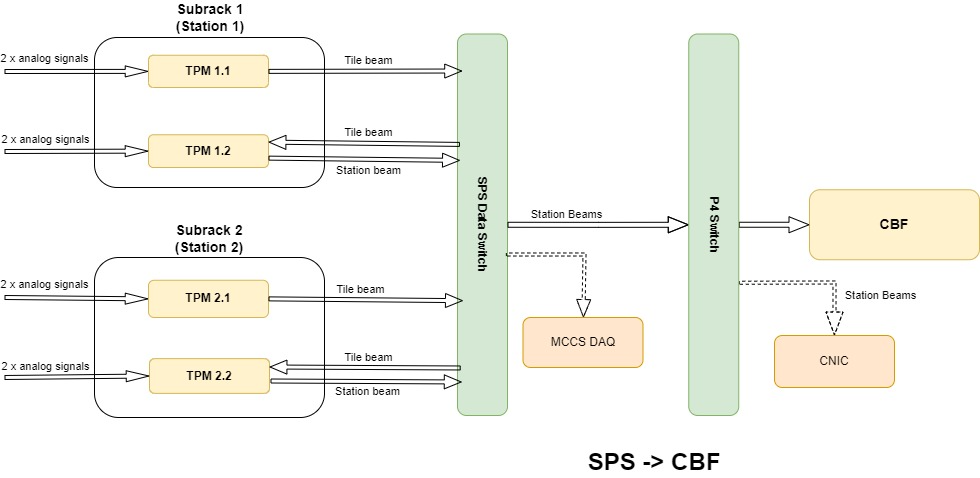

## Install required packages

In [ ]:
# pragma pylint: disable=too-many-branches
# pragma pylint: disable=no-else-return
# pragma pylint: disable=too-many-nested-blocks
# pragma pylint: disable=import-error
# pragma pylint: disable=line-too-long

In [ ]:
!pip install -q  --force "git+https://gitlab.com/ska-telescope/aavs-system.git#egg=aavs-system&subdirectory=python" lockfile future

In [ ]:
!pip install tabulate

In [ ]:
!pip install scapy

## Imports

In [ ]:
import json
import logging
import sys
import time
from datetime import datetime

import configuration
import display
import numpy as np
import test_frame
from IPython.display import Markdown
from IPython.display import display as ipython_display
from IPython.display import display_markdown
from tango import DeviceProxy, DevSource, DevState

from aiv_utils.low_utils import print_port_status

sys.path.append("/home/jovyan/ska-low-itf-scripts/database/scripts/support")


RFC_FORMAT = "%Y-%m-%dT%H:%M:%S.%fZ"

logger = logging.getLogger(__name__)

## Chart Information

In [ ]:
charts = configuration.get_charts()
pods = configuration.get_pods()
tango_config = configuration.get_tango_config()

print("CHARTS")
display.as_json_tree(charts)
print("\nPODS")
display.as_json_tree(pods)
print("\nTANGO CONFIGURATION")
display.as_json_tree(tango_config)

## Constants

In [ ]:
TIMEOUT = 60.0
INTERVAL = 0.5

## Pure helper functions
These functions operate only on their arguments and should be reusable in other notebooks

In [ ]:
def get_sut_device(fqdn):
    device = DeviceProxy(f"tango-databaseds.sut:10000/{fqdn}")
    # ensure we don't get cached data
    device.set_source(DevSource.DEV)
    return device


def get_te_device(fqdn):
    device = DeviceProxy(f"tango-databaseds.test-environment:10000/{fqdn}")
    # ensure we don't get cached data
    device.set_source(DevSource.DEV)
    return device

In [ ]:
def wait_for_tpms(tiles, desired_state="Initialised"):
    n = len(tiles)
    num_good = 0
    while num_good != n:
        num_good = len(
            [tile for tile in tiles if tile.tileprogrammingstate == desired_state]
        )
        bad_tiles = [
            tile for tile in tiles if tile.tileprogrammingstate != desired_state
        ]
        print(f"{num_good} of {n} are {desired_state} ...")
        for tile in bad_tiles:
            print(
                f"{tile.name()} is {tile.tileprogrammingstate} not {desired_state} ..."
            )
        time.sleep(5)
    print(f"All tpms are {desired_state}")

In [ ]:
def wait_for_state(device, state, timeout=TIMEOUT):
    """
    Wait for device state to have the expected value.

    :param device: device client
    :param state: the expected state
    :param timeout: timeout in seconds
    """

    def predicate():
        return device.state() == state

    description = f"DeviceProxy state {state.name}"
    logger.info(f"Waiting for device state {state.name}...")
    wait_for_predicate(predicate, description, timeout=timeout)


def wait_for_predicate(predicate, description, timeout=TIMEOUT, interval=INTERVAL):
    """
    Wait for predicate to be true.

    :param predicate: callable to test
    :param description: description to use if test fails
    :param timeout: timeout in seconds
    :param interval: interval between tests of the predicate in seconds

    """
    start = time.time()
    while True:
        if predicate():
            break
        if time.time() >= start + timeout:
            raise TimeoutError(f"{description} not achieved after {timeout} seconds")
        time.sleep(interval)

In [ ]:
def get_tiles(station):
    tile_fqdns = station.get_property("TileFQDNS")["TileFQDNS"]
    return [get_sut_device(fqdn) for fqdn in tile_fqdns]

In [ ]:
def check_logical_ids_station(station):
    ids = [tile.logicaltileid for tile in get_tiles(station)]
    assert ids == [0, 1], f"Expecting logical ids to be [0,1]: actual: {ids}"

In [ ]:
def show_tile_routing(tiles):
    table = []
    routes = []
    for tile in tiles:
        core_configs = json.loads(tile.get40gcoreconfiguration("{}"))
        for core_config in core_configs:
            core_id = core_config["core_id"]
            arp_table = core_config["arp_table_entry"]
            src_ip = core_config["source_ip"]
            dest_ip = core_config["destination_ip"]
            dest_port = core_config["destination_port"]
            if dest_ip == csp_ingest_ip:
                dest = "CSP"
            elif dest_ip == daq_ip:
                dest = "DAQ"
            else:
                dest = dest_ip
            routes.append(
                {
                    "tile": tile.name(),
                    "core": core_id,
                    "arp": arp_table,
                    "src": src_ip,
                    "dest": dest,
                    "port": dest_port,
                }
            )
    for route in routes:
        table.append(
            f"TILE {route['tile']} CORE {route['core']} ARP {route['arp']}: {route['src']} --> {route['dest']}/{route['port']}"
        )
    for line in sorted(table):
        print(line)

## Tango Devices

In [ ]:
awg = get_te_device("low-itf/awg/1")  # Arbritrary Waveform Generator (AWG5208)

In [ ]:
prog_atten1 = get_te_device("low-itf/progattenuator/1")

In [ ]:
prog_atten2 = get_te_device("low-itf/progattenuator/2")

In [ ]:
subrack1 = get_sut_device("low-mccs/subrack/subrack1")

In [ ]:
subrack2 = get_sut_device("low-mccs/subrack/subrack2")

In [ ]:
tile1 = get_sut_device("low-mccs/tile/01")  # tile1 seems to be bad

In [ ]:
tile2 = get_sut_device("low-mccs/tile/02")

In [ ]:
tile3 = get_sut_device("low-mccs/tile/03")

In [ ]:
tile4 = get_sut_device("low-mccs/tile/04")

In [ ]:
cnic = get_sut_device("low-cbf/cnic/1")

In [ ]:
daq = get_sut_device("low-mccs/daqreceiver/station1")

In [ ]:
connector = get_sut_device("low-cbf/connector/0")

In [ ]:
allocator = get_sut_device("low-cbf/allocator/0")

In [ ]:
station1 = get_sut_device("low-mccs/spsstation/station1")

In [ ]:
station2 = get_sut_device("low-mccs/spsstation/station2")

In [ ]:
pasdbus = get_sut_device("low-mccs/pasdbus/itf")

In [ ]:
sp6t = DeviceProxy("low-itf/sp6t/1")  # Switch Matrix (RC-2SP6T-A18)

In [ ]:
subracks = [subrack1, subrack2]

stations = [station1, station2]

devices = [
    awg,
    subrack1,
    subrack2,
    tile1,
    tile2,
    tile3,
    tile4,
    daq,
    connector,
    prog_atten1,
    prog_atten2,
    allocator,
    cnic,
    station1,
    station2,
    sp6t,
    pasdbus,
]

tiles = [tile1, tile2]
station2_tiles = [tile3, tile4]

In [ ]:
frame = test_frame.TestFrame(tiles, ["adminMode", "status", "tileprogrammingstate"])

## Non-pure helper functions
These functions use tango device names in the body without supplying them as arguments. This makes the function invocations shorter and more readable, but hinders reusability as the functions may not work if they are copied into another notebook.

In [ ]:
def turnon_smartbox_ports(smartbox_number):
    cmd = {
        "smartbox_number": smartbox_number,
        "port_powers": [True] * 12,
        "stay_on_when_offline": True,
    }
    cmd_json = json.dumps(cmd)
    # pasdbus.turnsmartboxporton(cmd_json)
    pasdbus.setsmartboxportpowers(cmd_json)

In [ ]:
def turnoff_smartbox_ports(smartbox_number):
    cmd = {
        "smartbox_number": smartbox_number,
        "port_powers": [False] * 12,
        "stay_on_when_offline": True,
    }
    cmd_json = json.dumps(cmd)
    pasdbus.setsmartboxportpowers(cmd_json)

In [ ]:
def reset_smartbox_port_breaker(smartbox_number, smartbox_port):
    cmd = {"smartbox_number": smartbox_number, "port_number": smartbox_port}
    cmd_json = json.dumps(cmd)
    pasdbus.resetsmartboxportbreaker(cmd_json)

In [ ]:
def get_ports_with_breakers_set(sb):
    attr = f"smartbox{sb}portbreakerstripped"
    boolean_array = getattr(pasdbus, attr)
    # np.where returns a 1 tuple for a 1 dim array and port operations are 1 based
    ports = np.where(boolean_array)[0] + 1
    return ports

In [ ]:
def reset_breakers():
    for sb in [1, 2]:
        for (
            port
        ) in get_get_ports_with_breakers_set(  # noqa: F821 # pylint: disable=undefined-variable
            sb
        ):
            reset_smartbox_port_breaker(sb, port)

In [ ]:
def untrip_breakers():
    sb1_breakers = any(pasdbus.smartbox1portbreakerstripped)
    sb2_breakers = any(pasdbus.smartbox2portbreakerstripped)
    if sb1_breakers:
        print("smartbox 1 breakers have been tripped")
    if sb2_breakers:
        print("smartbox 2 breakers have been tripped")

    if sb1_breakers or sb2_breakers:
        print("resetting the breakers ...")
        reset_breakers()
    else:
        print("no breakers tripped!")

In [ ]:
def sanity_check(func):
    def wrapped(*args, **kwargs):
        sb1_breakers = any(pasdbus.smartbox1portbreakerstripped)
        sb2_breakers = any(pasdbus.smartbox2portbreakerstripped)
        if any([sb1_breakers, sb2_breakers]):
            reset_breakers()

        time.sleep(1)
        return func(*args, **kwargs)

    return wrapped

In [ ]:
def configure_daq(folder, num_tiles=2):
    print(f"daq directory = {folder} num tiles = {num_tiles}")
    daq.Configure(json.dumps({"directory": folder, "nof_tiles": num_tiles}))


def start_daq():
    daq.Start('{"modes_to_start": "RAW_DATA,CHANNEL_DATA"}')


def turn_on_tpms():
    for subrack in subracks:
        subrack.poweruptpms()


def turn_off_everything():
    for subrack in subracks:
        print(f"powering off tpms in subrack {subrack.name()}...")
        subrack.powerdowntpms()
    print("stopping daq ...")
    daq.Stop()


def turn_on_everything():
    for device in devices:
        print(f"putting device {device.name()} online...")
        device.adminMode = 0
    for subrack in subracks:
        print(f"powering on tpms in subrack {subrack.name()}...")
        subrack.poweruptpms()


def configure_daq_tpm(daq, tpm, dest_ip=None, dest_port=None):
    # by default send data to daq
    if dest_ip:
        tpm_config = {
            "mode": "10G",
            "destination_ip": dest_ip,
            "destination_port": dest_port,
            "channel_payload_length": 8192,
        }

    else:
        daq_status = json.loads(daq.daqstatus())
        tpm_config = {
            "mode": "10G",
            "destination_ip": daq_status["Receiver IP"][0],
            "destination_port": daq_status["Receiver Ports"][0],
            "channel_payload_length": 8192,
        }
    tpm.SetLmcDownload(json.dumps(tpm_config))
    return tpm_config


def tpm_tone_generator(tpm, freq=200e6, amp=0.5, noise_amp=0.1):
    print(f"Setting up tone generator for tpm {tpm.name()}:")
    tpm.adminMode = 2  # Maintainence mode
    print("put tpm into maintainance mode(=2) ..")
    assert tpm.adminMode == 2

    print(f"freq = {freq} Hz amp = {amp} noise amp = {noise_amp}")
    tpm.ConfigureTestGenerator(
        json.dumps(
            {
                "tone_frequency": freq,
                "tone_amplitude": amp,
                "noise_amplitude": noise_amp,
            }
        )
    )

In [ ]:
def setup_cnic(cnic):
    cnic_fw_version = "0.1.9"
    force_download = False
    # if the firmware lost after reboot, we won't have this attribute
    update_firmware = (
        not hasattr(cnic, "activePersonality") or cnic.activePersonality != "cnic"
    )

    if update_firmware or force_download:
        cnic.set_timeout_millis(300_000)
        cnic.SelectPersonality(
            json.dumps(
                {
                    "version": cnic_fw_version,
                    "source": "gitlab",
                    "memory": "4095Ms:4095Ms:4095Mi:4095Mi",
                }
            )
        )

In [ ]:
def configure_tpm(tpm, dest_ip):
    # this works as is !
    csp_ingest_ip = dest_ip
    lmc_ip = dest_ip
    csp_rounding = 3
    tpm.on()
    t = 0
    while tpm.tileprogrammingstate not in ["Initialised", "Synchronised"]:
        print(f"{t}: {tpm.tileprogrammingstate}")
        time.sleep(2)
        t = t + 2
        if t > 60:
            break
    if t > 60:
        print("Initialisation failed")
    elif tpm.tileprogrammingstate == "Initialised":
        print(f"{t}: {tpm.tileprogrammingstate}")
        tpm.ConfigureStationBeamformer(
            json.dumps(
                {
                    "start_channel": 192,
                    "n_channels": 8,
                    "is_first": True,
                    "is_last": True,
                }
            )
        )
        start_time = datetime.strftime(
            datetime.fromtimestamp(int(time.time()) + 2), RFC_FORMAT
        )
        tpm.StartAcquisition(json.dumps({"start_time": start_time}))
        time.sleep(3)
    if tpm.tileprogrammingstate == "Synchronised":
        tpm.statictimedelays = np.zeros([32], dtype=int)
        tpm.channeliserRounding = [csp_rounding] * 512
        tpm.cspRounding = [0] * 384
        tpm.SetLmcDownload(json.dumps({"destination_ip": lmc_ip, "mode": "10g"}))
        tpm.SetLmcIntegratedDownload(
            json.dumps({"destination_ip": lmc_ip, "mode": "10g"})
        )
        tpm.Configure40GCore(
            json.dumps(
                {
                    "core_id": 0,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
        tpm.Configure40GCore(
            json.dumps(
                {
                    "core_id": 1,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
    print(f"{tpm.fpgaframetime}: Tile is in state {tpm.tileprogrammingstate}")
    time.sleep(0.5)  # to allow for the total power detector to compute the total power
    print(f"Input levels: {tpm.adcPower}")

In [ ]:
def get_cnic_port(cnic, allocator):
    hardware_connections = allocator.get_property("hardware_connections")[
        "hardware_connections"
    ]
    for line in hardware_connections:
        if line.endswith(cnic.serialnumber):
            _, port, _, _ = line.split()
            _, cnic_port = port.split("=")
            break
    return cnic_port

In [ ]:
def connect_to_switch():
    switch_config = {"Switch": "10.134.0.22:50052"}
    connector.connecttoswitch(json.dumps(switch_config))

In [ ]:
def route_data_to_cnic():
    connector.clearbasictable("")
    cnic_port = get_cnic_port(cnic, allocator)
    csp_port = "2/0"
    connector.AddBasicEntry(
        json.dumps({"basic": [{"src": {"port": csp_port}, "dst": {"port": cnic_port}}]})
    )

In [ ]:
def setup_spead_routing(channels, dest_port, beam=0, clear=False):
    if clear:
        connector.ClearSpeadUnicastTable("")
    spead_cfg = {
        "spead": [
            {
                "src": {"frequency": channel, "beam": beam, "sub_array": 1},
                "dst": {"port": dest_port},
            }
            for channel in channels
        ]
    }

    try:
        connector.UpdateSpeadUnicastEntry(json.dumps(spead_cfg))
    except Exception as ex:
        print(f"Error updating spead unicast table: {ex}")

In [ ]:
def setup_cnic_capture(
    cnic, filename="leecnic", run="", num_packets=512, packet_size=8306
):
    rx_pcap = f"/test-data/{filename}_{run}.pcap"
    rx_cfg = {
        "method": "receive_pcap",
        "arguments": {
            "out_filename": rx_pcap,
            "packet_size": packet_size,
            "n_packets": num_packets,
        },
    }
    cnic.CallMethod(json.dumps(rx_cfg))

In [ ]:
def print_tile_configuration(tile):
    config = tile.get40gcoreconfiguration("{}")
    print(f"{tile.name()} configuration:")
    ipython_display(Markdown(config))

In [ ]:
def print_tiles_configuration():
    for tile in tiles:
        print_tile_configuration(tile)

In [ ]:
def view_json_dict(s):
    display_markdown(Markdown(s))

In [ ]:
def setup_attenuator(atten_dev, attenuation=2.5):
    for atten_channel in [1, 2, 3, 4]:
        atten_attribute = f"channel_{atten_channel}"
        print(f"setting {atten_dev.name()} {atten_attribute} to {attenuation} ...")
        atten_dev.write_attribute(atten_attribute, attenuation)

In [ ]:
def start_analog_chain(attenuation=2.5):
    print("starting analog chain ...")
    print("ensure safe levels in preadus ...")
    for tile in tiles:
        tile.preadulevels = [24.0] * 32
        print(f"tile {tile.name()} preadu levels = {tile.preadulevels}")
    time.sleep(3)
    sp6t.switch_a = 1
    prog_atten1.adminMode = 0
    time.sleep(2)
    print(
        f"setting programmable attenuator {prog_atten1.name()} attenuation to {attenuation} ..."
    )
    setup_attenuator(prog_atten1, attenuation)

    prog_atten2.adminMode = 0

    print(
        f"setting programmable attenuator {prog_atten2.name()} attenuation to {attenuation} ..."
    )
    setup_attenuator(prog_atten2, attenuation)
    time.sleep(5)
    awg.adminMode = 0
    time.sleep(2)
    print("pressing play on AWG ...")
    awg.Play()
    print("Analog chain started")

In [ ]:
def stop_analog_chain():
    print("Stopping the AWG waveforms")
    awg.stop()

In [ ]:
def configure_tpms_csp(csp_ingest_ip):
    for tile in tiles:
        tile.Configure40GCore(
            json.dumps(
                {
                    "core_id": 0,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
        tile.Configure40GCore(
            json.dumps(
                {
                    "core_id": 1,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )

In [ ]:
def setup_ports(connector):
    # these ports already setup
    connector.LoadPorts(
        '{"Physical": [ {"port": "1/0", "fec": "none", "speed": "10G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    # TPM link 100G
    connector.LoadPorts(
        '{"Physical": [ {"port": "2/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    # Alveos
    connector.LoadPorts(
        '{"Physical": [ {"port": "7/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    connector.LoadPorts(
        '{"Physical": [ {"port": "9/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    connector.LoadPorts(
        '{"Physical": [ {"port": "13/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    connector.LoadPorts(
        '{"Physical": [ {"port": "15/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    connector.LoadPorts(
        '{"Physical": [ {"port": "17/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    connector.LoadPorts(
        '{"Physical": [ {"port": "11/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )

    connector.LoadPorts(
        '{"Physical": [ {"port": "31/0", "fec": "none", "speed": "10G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )
    # SDP Port 32
    connector.LoadPorts(
        '{"Physical": [ {"port": "32/0", "fec": "none", "speed": "100G", "autoneg": "disable", "mac": "11:22:33:44:55:66"}]}'
    )

In [ ]:
def setup_daq(daq, folder_name="/product/lee", num_tiles=2, modes=None):
    print("setting up daq ..")
    if daq.adminMode != 0:
        print("taking daq out of admin mode ..")
        daq.adminMode = 0
        wait_for_predicate(lambda: daq.adminMode == 0, "daq normal mode")

    print("stopping daq ..")
    daq.Stop()
    config = {"directory": folder_name, "nof_tiles": num_tiles}
    print(f"configuring daq: config = {config} ..")
    daq.Configure(json.dumps(config))
    if modes is None:
        modes_csv = ",".join(
            ["RAW_DATA", "CHANNEL_DATA", "BEAM_DATA", "STATION_BEAM_DATA"]
        )
    else:
        modes_csv = ",".join(modes)

    modes_to_start = {"modes_to_start": modes_csv}
    print(f"starting daq in modes {modes_csv} ...")
    daq.Start(json.dumps(modes_to_start))

In [ ]:
def get_daq_ip():
    status = json.loads(daq.daqstatus())
    return status["Receiver IP"][0]

In [ ]:
def start_data_acquisition(daq, tiles, folder_name="/product/lee"):
    # modes_csv = ",".join(["RAW_DATA","CHANNEL_DATA","BEAM_DATA",
    #                       "CONTINUOUS_CHANNEL_DATA","INTEGRATED_BEAM_DATA",
    #                       "INTEGRATED_CHANNEL_DATA","STATION_BEAM_DATA"])
    modes_csv = ",".join(["RAW_DATA", "CHANNEL_DATA", "BEAM_DATA", "STATION_BEAM_DATA"])
    print(f"acquiring raw data from tiles {[tile.name() for tile in tiles]} ...")
    print("stop any current data tranmission ..")
    for tile in tiles:
        try:
            tile.stopdatatransmission()
        except Exception as ex:
            print(f"Error stopping data transmission for {tile.name()}: {ex}")
    print("stopping daq..")
    if daq.adminMode != 0:
        daq.adminMode = 0

    while daq.adminMode != 0:
        time.sleep(1)

    print("stopping daq..")
    daq.Stop()
    time.sleep(5)
    daq_config = {"directory": folder_name, "nof_tiles": len(tiles)}
    print(f"configuring daq: {daq_config}")
    daq.Configure(json.dumps(daq_config))
    modes = {"modes_to_start": modes_csv}
    print(f"starting daq in modes: {modes}")
    daq.Start(json.dumps(modes))

    for tile in tiles:
        print(f"configuring tile {tile.name()} for daq ..")
        configure_daq_tpm(daq, tile)

    for tile in tiles:
        print(f"start acquisition for tile {tile.name()}")
        tile.startacquisition("{}")

    wait_for_tpms(tiles, "Synchronised")

In [ ]:
def init_stations(sps_stations):
    # Lifted verbatim from mccs notebooks
    # Executes initialization if required.
    # If all tiles are synchronized, it is assumed they are properly so
    #

    if any(
        any(state != "Synchronised" for state in station.tileProgrammingState)
        for station in sps_stations
    ):
        print("Must turn on and reinitialise stations")
        reinitialize = False  # second  initialization is required if not all tiles
        # are initialised in first cycle
        # Turn on tiles which are off and initialises tiles whch are off.

        for station in sps_stations:
            if station.state() == DevState.ON:
                station.Initialise()  # re-initialise if already ON
            elif station.state() in (
                DevState.OFF,
                DevState.STANDBY,
            ):
                station.on()  # ON includes reinitialisation
            else:
                station.on()  # turn on what is not already on, but must reinitialze
                reinitialize = True
        timeout = 60  # seconds
        print("Waiting for all stations to come ON and initialise")
        while timeout > 0:
            time.sleep(2)
            if all(
                all(
                    status in ("Initialised", "Synchronized")
                    for status in station.tileProgrammingState
                )
                for station in sps_stations
            ):
                break
            timeout -= 2
        if timeout <= 0:
            print("Error: timeout in waiting for stations to initialize")
        else:
            time.sleep(2)  # to wait for station intialisation to complete
            if reinitialize:
                # re-initialisation required. Some stations were not ON or OFF
                for station in sps_stations:
                    station.initialise()
                    timeout = 60  # seconds
                    print("Waiting for all remaining unprogrammed tiles initialise")
                    while timeout > 0:
                        time.sleep(2)
                        if all(
                            all(
                                status == "Initialised"
                                for status in station.tileProgrammingState
                            )
                            for station in sps_stations
                        ):
                            break
                    if timeout <= 0:
                        print("Error: timeout in waiting for tiles to initialize")
            #
            # Synchronize all stations
            #
            time.sleep(2)
            print("Synchronize all stations")
            start_time = datetime.strftime(
                datetime.fromtimestamp(int(time.time()) + 2), RFC_FORMAT
            )
            for station in sps_stations:
                station.StartAcquisition(json.dumps({"start_time": start_time}))
            #
            # check that synchronization worked
            #
            time.sleep(3)
    #
    # Check for successful synchronisation
    if any(
        any(state != "Synchronised" for state in station.tileprogrammingstate)
        for station in sps_stations
    ):
        print("MCCS stations not all synchronised :(")
        for station in sps_stations:
            print(f"{station.name()}: state = {station.tileprogrammingstate}")
        return False
    else:
        print("MCCS stations all synchronised :)")
        return True

In [ ]:
def setup_beamformer_for_station(station, start_channel=64):
    num_channels = 384
    beam_index = 0
    subarray_id = 1
    subarray_logical_channel = 0
    subarray_beam_id = 0
    substation_id = 0
    aperture_id = 0
    entry_block = [
        start_channel,
        num_channels,
        beam_index,
        subarray_id,
        subarray_logical_channel,
        subarray_beam_id,
        substation_id,
        aperture_id,
    ]
    station.SetBeamformerRegions(entry_block)
    station.statictimedelays = np.zeros([512], dtype=int)
    station.preaduLevels = list(range(32)) * 16
    station.channeliserRounding = [3] * 512
    station.cspRounding = [0] * 384

In [ ]:
for device in devices:
    if hasattr(device, "adminMode"):
        try:
            device.adminMode = 0
            print(f"Device {device.name()} taken out of adminMode")
        except Exception as ex:
            print(f"{device.name()} : {ex}")

## Setup devices prior to runs

In [ ]:
turnon_smartbox_ports(1)

In [ ]:
subrack1.on()

In [ ]:
subrack1.status()

In [ ]:
pasdbus.adminMode

In [ ]:
turnoff_smartbox_ports(1)

In [ ]:
turnon_smartbox_ports(1)

In [ ]:
pasdbus.InitializeSmartbox(1)

In [ ]:
pasdbus.InitializeSmartbox(2)

In [ ]:
subrack1.tpmpowers

In [ ]:
subrack2.tpmpowers

In [ ]:
subrack1.powerdowntpms()

In [ ]:
subrack1.tpmpowers

In [ ]:
subrack2.powerdowntpms()

In [ ]:
station1.tileprogrammingstate

In [ ]:
station2.tileprogrammingstate

In [ ]:
untrip_breakers()

In [ ]:
pasdbus.smartbox1portbreakerstripped

In [ ]:
subrack1.poweruptpms()

In [ ]:
frame.check()

In [ ]:
wait_for_tpms(tiles)

In [ ]:
wait_for_predicate(lambda: sum(subrack1.tpmpowers) > 150, "subrack 1 tpm powers")

In [ ]:
# The following sets up the logical tile ids for station 1
station1.adminMode = 1
time.sleep(5)
station1.adminMode = 0

for tile in get_tiles(station1):
    print(f"station 1 {tile.name()} is logical tile {tile.logicaltileid}")

In [ ]:
check_logical_ids_station(station1)

In [ ]:
for tile in get_tiles(station1):
    assert (
        tile.stationid == 1
    ), f"{tile.name()} station id expected: 1 actual: {tile.stationid}"

## Initial Setup

### Analog chain
Analog chain / Sky Signal Generator needs to be setup as per the testcase in Jama ( requires AWG config loaded in and hardware connections for XY polarisation setup.)

#### Start the AWG 

In [ ]:
start_analog_chain()

### P4 Setup

In [ ]:
switch_config = {"Switch": "10.134.0.22:50052"}

connector.connecttoswitch(json.dumps(switch_config))

In [ ]:
setup_cnic(cnic)

In [ ]:
cnic.activePersonality

In [ ]:
get_cnic_port(cnic, allocator)

In [ ]:
route_data_to_cnic()

In [ ]:
connector.basicroutingtable

In [ ]:
setup_spead_routing(list(range(513)), get_cnic_port(cnic, allocator))

In [ ]:
connector.speadUnicastRoutingTable

In [ ]:
print_port_status(connector)

### CSP Endpoint Config

In [ ]:
csp_ingest_ip = "10.0.0.20"

In [ ]:
csp_mac = "aa:bb:cc:dd:ee:ff"

In [ ]:
arp_routing_table = json.loads(connector.arproutingtable)

In [ ]:
if not [
    route
    for route in arp_routing_table["ARP"]
    if route["IP"] == csp_ingest_ip and route["Mac"] == csp_mac
]:
    print("Adding csp P4 config ..")
    connector.addarpentry(
        json.dumps(
            {
                "arp": [
                    {
                        "ip": {"address": csp_ingest_ip},
                        "mac": {"address": csp_mac},
                    }
                ]
            }
        )
    )
else:
    print(f"csp already configured in P4: IP = {csp_ingest_ip} MAC = {csp_mac}")

### Daq config
Setup daq config for station 1

In [ ]:
setup_daq(daq)

In [ ]:
daq_ip = get_daq_ip()

In [ ]:
print(f"daq ip = {daq_ip}")

In [ ]:
daq.daqstatus()

### Tile Config - Station 1

In [ ]:
tiles

In [ ]:
frame.check()

#### Configure TPMS to talk to CSP

In [ ]:
for tile in tiles:
    try:
        print(f"configuring {tile.name()} csp ..")
        tile.on()
        tile.Configure40GCore(
            json.dumps(
                {
                    "core_id": 0,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
        tile.Configure40GCore(
            json.dumps(
                {
                    "core_id": 1,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
    except Exception as ex:
        print(f"Error setting up {tile.name()}: {ex}")

#### Configure TPMS to talk to the DAQ

In [ ]:
for tile in tiles:
    configure_daq_tpm(daq, tile)

In [ ]:
show_tile_routing(tiles)

## Station 1 tests

In [ ]:
frame.check()

In [ ]:
for tile in tiles:
    print(f"start acquisition for tile {tile.name()}")
    tile.startacquisition("{}")

In [ ]:
wait_for_tpms(tiles, "Synchronised")

#### Raw Data

#### Feed analog signals to each of the two TPMs within a subrack, which is also a virtual station. Signals are fed to a pair of X-polarisation inputs and a pair of Y-polarisation inputs. The sampled time sequence is acquired using MCCS DAQ.

The pasd smartbox port breakers seem to get tripped regularly which interferes with the test: We untrip the breakers here if needed

In [ ]:
untrip_breakers()

In [ ]:
frame.check()

In [ ]:
for tile in tiles:
    tile.senddatasamples(json.dumps({"data_type": "raw"}))

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/raw_burst_0_20240130_20181_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/raw_burst_1_20240130_20181_0.hdf5

#### Channelised Data

The channelised digital data stream is acquired using the MCCS DAQ. 

In [ ]:
untrip_breakers()

In [ ]:
for tile in tiles:
    tile.senddatasamples(json.dumps({"data_type": "channel"}))

In [ ]:
%run -m pydaq.daq_plotter -- --log \
--plot_type spectrum \
-f /home/jovyan/shared-data/lee/channel_burst_0_20240130_20504_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --log \
--plot_type spectrum \
-f /home/jovyan/shared-data/lee/channel_burst_1_20240130_20504_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/channel_burst_0_20240130_20504_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/channel_burst_1_20240130_20504_0.hdf5

#### Tile Beam Data

The tile beam data output from individual TPMs is acquired using the MCCS DAQ receiver. 

The tile beam former successfully combines the channelised data to generate tile beam data. The power spectrum of this data set demonstrates success of the TPM tile beam former in combining inputs to separate samplers that belong to same virtual tile.

In [ ]:
untrip_breakers()

In [ ]:
setup_beamformer_for_station(station1, start_channel=0)

In [ ]:
frame.check()

In [ ]:
show_tile_routing(tiles)

In [ ]:
for tile in tiles:
    tile.startbeamformer("{}")
    tile.senddatasamples(json.dumps({"data_type": "beam"}))

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared-data/lee/beamformed_burst_0_20240130_20873_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared-data/lee/beamformed_burst_1_20240130_20873_0.hdf5

#### Station Beam Data  ( Station 1 )

The station beam data aggregated in the SPEAD packet buffer is acquired by the MCCS DAQ.

The station beam data stream is examined to check that tile beams are successfully added in a cumulative fashion one after the other to form cumulative station beams.


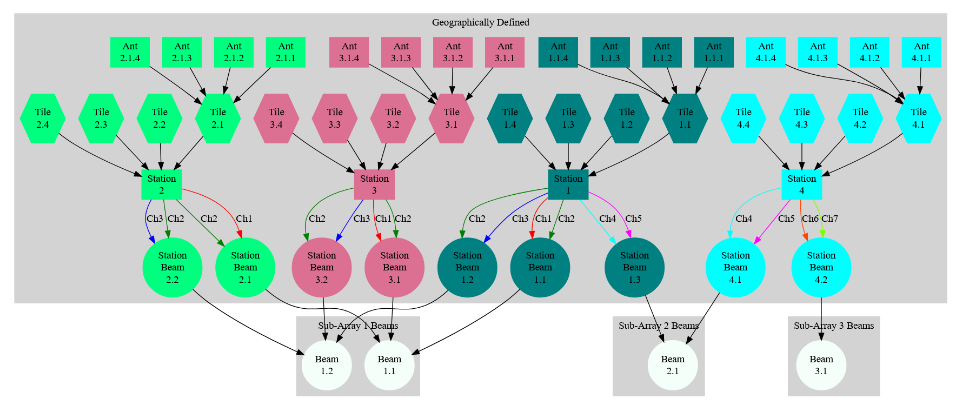

( Taken from https://confluence.skatelescope.org/display/SE/MCCS+Station+Beam+Device )

The Analog Chain --> CSP engineering model has two MCCS Stations :
    
    Station 1 with tpms 1.1 and 1.2   ( Subrack 1 )

    Station 2 with tpms 2.1 ans 2.2   ( Subrack 2 )
    
    
 Sine wave signals are played from channels 3, 4 , 7 and 8 of an arbritrary waveform generator and fed into the tpms as in the table below:

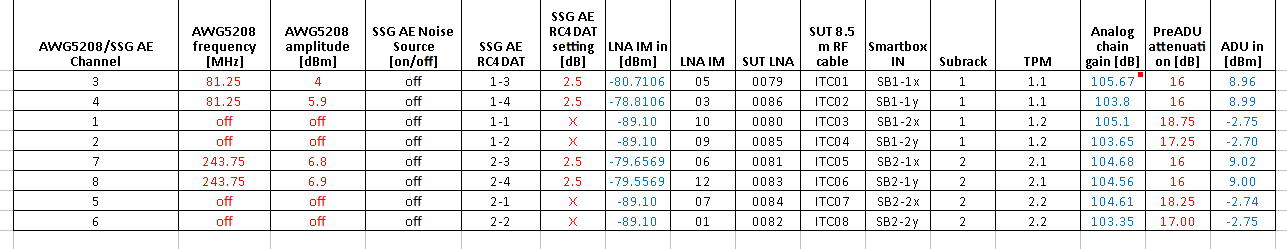

In [ ]:
frame = test_frame.TestFrame(
    get_tiles(station1), ["adminMode", "status", "tileprogrammingstate"]
)

In [ ]:
frame.check()

Tiles have been setup at deployment time to put tiles 1 and 2 in station 1 and 3 and 4 in station 2:
The fqdn for each tile is a property of the station tango device

We here iterate through the fqdns and retreive the associated tile device to show the partitioning.

Putting the station in and out of adminMode causes the logical ids of the tiles to be assigned correctly.

In [ ]:
untrip_breakers()

In [ ]:
station1.adminMode = 1

In [ ]:
station1.adminMode = 0

In [ ]:
for tile in get_tiles(station1):
    print(f"station 1 {tile.name()} is logical tile {tile.logicaltileid}")

In [ ]:
tile1.stationid

In [ ]:
tile2.stationid

#### Tile routing

The following shows routing of the station's tiles:

Tile 1 should feed into tile 2 which in turn sends SPEAD packets to CSP.

The P4 Switch in the ITF has been programmed to route SPEAD packets hitting the CSP
ingest port to the CNIC packet capture FPGA device. 


Initialise the station which sets up the daisy chaining of the tiles

In [ ]:
station1.initialise()

In [ ]:
show_tile_routing(tiles)

#### Set the beamformer settings for station1
See https://developer.skao.int/projects/ska-low-mccs-spshw/en/latest/api/station/index.html#ska_low_mccs_spshw.station.SpsStation.SetBeamFormerRegions


In [ ]:
send_station_beam_to_daq = False

In [ ]:
start_channel = 64
num_channels = 384
beam_index = 0
subarray_id = 1
subarray_logical_channel = 0
subarray_beam_id = 0
substation_id = 0
aperture_id = 0

entry_block = [
    start_channel,
    num_channels,
    beam_index,
    subarray_id,
    subarray_logical_channel,
    subarray_beam_id,
    substation_id,
    aperture_id,
]

station1.SetBeamformerRegions(entry_block)
station1.statictimedelays = np.zeros([512], dtype=int)
station1.preaduLevels = [24.0] * 512
station1.channeliserRounding = [3] * 512
station1.cspRounding = [0] * 384

station1.SetLmcDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
station1.SetLmcIntegratedDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
if not send_station_beam_to_daq:
    print("sending station beam to csp/cnic..")
    station1.SetCspIngest(json.dumps({"destination_ip": csp_ingest_ip}))
else:
    print("sending station beam to mccs daq  ..")
    station1.SetCspIngest(json.dumps({"destination_ip": daq_ip}))

In [ ]:
station1.beamformertable.reshape(-1, 8)

In [ ]:
frame.check()

#### Calibration Settings for the station

These settings show a tight peak at 81.25MHz for station 1

In [ ]:
def station_calib_setup(station, antennas_in_beam, run_id, capture_before=False):
    print(f"run id = {run_id}")
    print(f"setting up calibration for {station.name()}")
    print("stopping station beamformer ..")
    station.stopbeamformer()
    num_antennas_in_station = 32
    bank = 0

    for tile in get_tiles(station):
        antenna_ids = [bank + i for i in range(16)]
        tile.antennaids = antenna_ids
        bank += 16

    gain = 2.0
    # represent 2x2 complex matrix as a flattened list of floats
    # i.e.
    #  re1 + i*im1, re2 + i*im2
    #  re3+i*im3,   re4 + i*im4
    # is represented as:
    # 8 floats :   [re1,im1,re2,im2,re3,im3,re4,im4]

    in_beam_matrix = [
        gain,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        gain,
        0.0,
    ]  # 2x2 scaled / gained complex identity matrix
    num_complex_components = 4  # 2x2 complex "Jones Matrix"
    num_real_components = 2 * num_complex_components
    out_of_beam_matrix = [0.0] * num_real_components
    num_channels = 384

    for antenna_id in range(num_antennas_in_station):
        if antenna_id in antennas_in_beam:
            # NB antenna id is prepended
            print(f"{antenna_id} in beam 0 - loading in beam matrix")
            station.LoadCalibrationCoefficients(
                [antenna_id] + in_beam_matrix * num_channels
            )
        else:
            print(f"{antenna_id} out of beam 0 - loading out of beam matrix")
            station.LoadCalibrationCoefficients(
                [antenna_id] + out_of_beam_matrix * num_channels
            )

    print("applying calibration ..")
    station.applycalibration("")
    time.sleep(5)
    start_time = datetime.strftime(
        datetime.fromtimestamp(int(time.time()) + 2), RFC_FORMAT
    )

    if capture_before:
        print(f"setting up cnic {cnic.name()}  capture file for run {run_id} ..")
        setup_cnic_capture(cnic, run=run_id)
        time.sleep(3)

    print(f"starting {station.name()} beamformer ..")
    start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
    station.StartBeamformer(json.dumps({"start_time": start_time}))
    time.sleep(5)

    if not capture_before:
        print(f"setting up cnic {cnic.name()}  capture file for run {run_id} ..")
        setup_cnic_capture(cnic, run=run_id)
        time.sleep(3)

    print(f"run {run_id} antennas in beam = {antennas_in_beam}")
    print(f"stopping {station.name()} beamformer..")
    time.sleep(3)
    station.stopbeamformer()
    print(f"run {run_id} ended. capture is /test-data/leecnic_{run_id}.pcap")

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(int(time.time()) + 2), RFC_FORMAT)
station1.StartAcquisition(json.dumps({"start_time": start_time}))

In [ ]:
wait_for_predicate(
    lambda: station1.tileprogrammingstate == ("Synchronised", "Synchronised"),
    "Synched",
)

In [ ]:
station1.tileprogrammingstate

In [ ]:
station_calib_setup(station1, list(range(32)), "testrun", capture_before=True)

In [ ]:
frame.check()

#### Send station beam to daq

In [ ]:
station1.stopbeamformer()

In [ ]:
send_station_beam_to_daq = True

In [ ]:
start_channel = 0
num_channels = 384
beam_index = 0
subarray_id = 1
subarray_logical_channel = 0
subarray_beam_id = 0
substation_id = 0
aperture_id = 0

entry_block = [
    start_channel,
    num_channels,
    beam_index,
    subarray_id,
    subarray_logical_channel,
    subarray_beam_id,
    substation_id,
    aperture_id,
]

station1.SetBeamformerRegions(entry_block)
station1.statictimedelays = np.zeros([512], dtype=int)
station1.preaduLevels = list(range(32)) * 16
station1.channeliserRounding = [3] * 512
station1.cspRounding = [0] * 384

station1.SetLmcDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
station1.SetLmcIntegratedDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
if not send_station_beam_to_daq:
    print("sending station beam to csp/cnic..")
    station1.SetCspIngest(json.dumps({"destination_ip": csp_ingest_ip}))
else:
    print("sending station beam to mccs daq  ..")
    station1.SetCspIngest(json.dumps({"destination_ip": daq_ip}))

In [ ]:
show_tile_routing(tiles)

In [ ]:
station1.isbeamformerrunning

In [ ]:
frame.check()

In [ ]:
station1.stopbeamformer()

In [ ]:
setup_daq(daq)

In [ ]:
daq.stop()

In [ ]:
station1.startbeamformer("{}")

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station1.SendDataSamples(json.dumps({"data_type": "beam", "start_time": start_time}))
print("sending beam data")

In [ ]:
%run -m pydaq.daq_plotter --    \
-f /home/jovyan/shared-data/lee/stationbeam_integ_0_20240130_22050_0.hdf5

## Station 2 tests

### Tile Config - Station 2

In [ ]:
tiles = get_tiles(station2)

In [ ]:
tiles

In [ ]:
subrack1.powerdowntpms()

In [ ]:
subrack2.poweruptpms()

In [ ]:
subrack2.powerdowntpms()

In [ ]:
wait_for_tpms(tiles)

In [ ]:
subrack1.tpmpowers

In [ ]:
subrack2.tpmpowers

In [ ]:
frame = test_frame.TestFrame(
    get_tiles(station2), ["adminMode", "status", "tileprogrammingstate"]
)

In [ ]:
frame.check()

#### Configure TPMS to talk to CSP

In [ ]:
for tile in tiles:
    try:
        print(f"configuring {tile.name()} csp ..")
        tile.on()
        tile.Configure40GCore(
            json.dumps(
                {
                    "core_id": 0,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
        tile.Configure40GCore(
            json.dumps(
                {
                    "core_id": 1,
                    "arp_table_entry": 0,
                    "destination_ip": csp_ingest_ip,
                }
            )
        )
    except Exception as ex:
        print(f"Error setting up {tile.name()}: {ex}")

#### Configure TPMS to talk to the DAQ

In [ ]:
for tile in tiles:
    configure_daq_tpm(daq, tile)

In [ ]:
show_tile_routing(tiles)

In [ ]:
frame.check()

In [ ]:
for tile in tiles:
    print(f"start acquisition for tile {tile.name()}")
    tile.startacquisition("{}")

In [ ]:
wait_for_tpms(tiles, "Synchronised")

#### Raw Data

#### Feed analog signals to each of the two TPMs within a subrack, which is also a virtual station. Signals are fed to a pair of X-polarisation inputs and a pair of Y-polarisation inputs. The sampled time sequence is acquired using MCCS DAQ.

The pasd smartbox port breakers seem to get tripped regularly which interferes with the test: We untrip the breakers here if needed

In [ ]:
untrip_breakers()

In [ ]:
setup_daq(daq)

In [ ]:
station2.preaduLevels = [24.0] * 512

In [ ]:
frame.check()

In [ ]:
for tile in tiles:
    tile.senddatasamples(json.dumps({"data_type": "raw"}))

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/raw_burst_0_20240130_22687_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/runs/jamatestrun/raw_burst_1_20240130_22687_0.hdf5

#### Channelised Data

The channelised digital data stream is acquired using the MCCS DAQ. 

In [ ]:
untrip_breakers()

In [ ]:
for tile in tiles:
    tile.senddatasamples(json.dumps({"data_type": "channel"}))

In [ ]:
%run -m pydaq.daq_plotter -- --log \
--plot_type spectrum \
-f /home/jovyan/shared-data/lee/channel_burst_0_20240130_22764_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- --log \
--plot_type spectrum \
-f /home/jovyan/shared-data/lee/runs/jamatestrun/channel_burst_1_20240130_22764_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/channel_burst_0_20240130_22764_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter --  \
-f /home/jovyan/shared-data/lee/channel_burst_1_20240130_22764_0.hdf5

#### Tile Beam Data

The tile beam data output from individual TPMs is acquired using the MCCS DAQ receiver. 

The tile beam former successfully combines the channelised data to generate tile beam data. The power spectrum of this data set demonstrates success of the TPM tile beam former in combining inputs to separate samplers that belong to same virtual tile.

In [ ]:
untrip_breakers()

In [ ]:
setup_beamformer_for_station(station2, start_channel=0)

In [ ]:
frame.check()

In [ ]:
show_tile_routing(tiles)

In [ ]:
for tile in tiles:
    tile.startbeamformer("{}")
    tile.senddatasamples(json.dumps({"data_type": "beam"}))

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared-data/lee/beamformed_burst_0_20240130_22972_0.hdf5

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared-data/lee/beamformed_burst_1_20240130_22972_0.hdf5

#### Station Beam Data  ( Station 2 )

The station beam data aggregated in the SPEAD packet buffer is acquired by the MCCS DAQ.

The station beam data stream is examined to check that tile beams are successfully added in a cumulative fashion one after the other to form cumulative station beams.


( Taken from https://confluence.skatelescope.org/display/SE/MCCS+Station+Beam+Device )

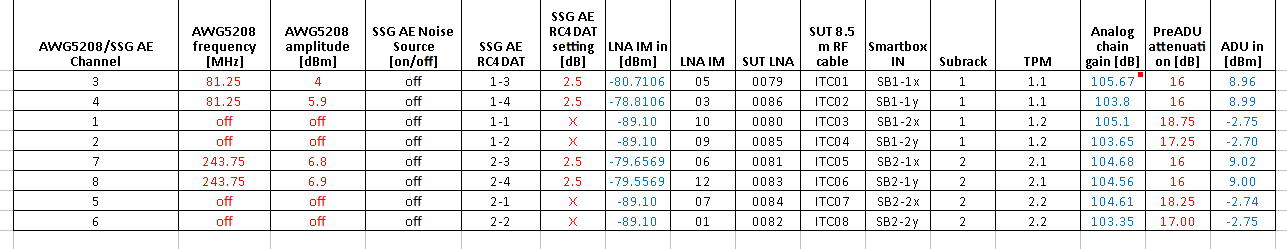

In [ ]:
frame = test_frame.TestFrame(
    get_tiles(station2), ["adminMode", "status", "tileprogrammingstate"]
)

In [ ]:
frame.check()

Tiles have been setup at deployment time to put tiles 1 and 2 in station 1 and 3 and 4 in station 2:
The fqdn for each tile is a property of the station tango device

We here iterate through the fqdns and retreive the associated tile device to show the partitioning.

Putting the station in and out of adminMode causes the logical ids of the tiles to be assigned correctly.

In [ ]:
untrip_breakers()

In [ ]:
station2.adminMode = 1

In [ ]:
station2.adminMode = 0

In [ ]:
for tile in get_tiles(station2):
    print(f"station 2 {tile.name()} is logical tile {tile.logicaltileid}")

In [ ]:
tile3.stationid

In [ ]:
tile4.stationid

#### Tile routing

The following shows routing of the station's tiles:

Tile 1 should feed into tile 2 which in turn sends SPEAD packets to CSP.

The P4 Switch in the ITF has been programmed to route SPEAD packets hitting the CSP
ingest port to the CNIC packet capture FPGA device. 


Initialise the station which sets up the daisy chaining of the tiles

In [ ]:
station2.initialise()

In [ ]:
show_tile_routing(tiles)

#### Set the beamformer settings for station1
See https://developer.skao.int/projects/ska-low-mccs-spshw/en/latest/api/station/index.html#ska_low_mccs_spshw.station.SpsStation.SetBeamFormerRegions


In [ ]:
send_station_beam_to_daq = False  # send to cnic

In [ ]:
start_channel = 64
num_channels = 384
beam_index = 0
subarray_id = 1
subarray_logical_channel = 0
subarray_beam_id = 0
substation_id = 0
aperture_id = 0

entry_block = [
    start_channel,
    num_channels,
    beam_index,
    subarray_id,
    subarray_logical_channel,
    subarray_beam_id,
    substation_id,
    aperture_id,
]

station2.SetBeamformerRegions(entry_block)
station2.statictimedelays = np.zeros([512], dtype=int)
station2.preaduLevels = [24.0] * 512
station2.channeliserRounding = [3] * 512
station2.cspRounding = [0] * 384

station2.SetLmcDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
station2.SetLmcIntegratedDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
if not send_station_beam_to_daq:
    print("sending station beam to csp/cnic..")
    station2.SetCspIngest(json.dumps({"destination_ip": csp_ingest_ip}))
else:
    print("sending station beam to mccs daq  ..")
    station2.SetCspIngest(json.dumps({"destination_ip": daq_ip}))

In [ ]:
station2.beamformertable.reshape(-1, 8)

#### Calibration Settings for the station

These settings show a tight peak at 81.25MHz for station 1

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(int(time.time()) + 2), RFC_FORMAT)
station2.StartAcquisition(json.dumps({"start_time": start_time}))

In [ ]:
wait_for_predicate(
    lambda: station2.tileprogrammingstate == ("Synchronised", "Synchronised"),
    "Synched",
)

In [ ]:
station2.tileprogrammingstate

In [ ]:
station_calib_setup(station2, list(range(32)), "testrunstation2", capture_before=True)

In [ ]:
frame.check()

#### Send station beam to daq

In [ ]:
send_station_beam_to_daq = True

In [ ]:
start_channel = 0
num_channels = 384
beam_index = 0
subarray_id = 1
subarray_logical_channel = 0
subarray_beam_id = 0
substation_id = 0
aperture_id = 0

entry_block = [
    start_channel,
    num_channels,
    beam_index,
    subarray_id,
    subarray_logical_channel,
    subarray_beam_id,
    substation_id,
    aperture_id,
]

station2.SetBeamformerRegions(entry_block)
station2.statictimedelays = np.zeros([512], dtype=int)
station2.preaduLevels = list(range(32)) * 16
station2.channeliserRounding = [3] * 512
station2.cspRounding = [0] * 384

station2.SetLmcDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
station2.SetLmcIntegratedDownload(json.dumps({"destination_ip": daq_ip, "mode": "10g"}))
if not send_station_beam_to_daq:
    print("sending station beam to csp/cnic..")
    station2.SetCspIngest(json.dumps({"destination_ip": csp_ingest_ip}))
else:
    print("sending station beam to mccs daq  ..")
    station2.SetCspIngest(json.dumps({"destination_ip": daq_ip}))

In [ ]:
show_tile_routing(tiles)

In [ ]:
station2.isbeamformerrunning

In [ ]:
frame.check()

In [ ]:
setup_daq(daq)

In [ ]:
station2.startbeamformer("{}")

In [ ]:
start_time = datetime.strftime(datetime.fromtimestamp(time.time() + 2), RFC_FORMAT)
station2.SendDataSamples(json.dumps({"data_type": "beam", "start_time": start_time}))
print("sending beam data")

In [ ]:
%run -m pydaq.daq_plotter -- --plot_type spectrum    \
-f /home/jovyan/shared-data/lee/stationbeam_integ_0_20240125_21717_0.hdf5

In [ ]:
station2.stopbeamformer()

In [ ]:
daq.stop()

In [ ]:
%run -m pydaq.daq_plotter -- \
-f /home/jovyan/shared-data/lee/stationbeam_integ_0_20240130_23503_0.hdf5